In [ ]:
%run VQAs_packages.ipynb

C:\Users\Yunya\AppData\Local\Temp\ipykernel_17960\1925216228.py:28: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import (Z, I, H, CircuitStateFn, StateFn)
C:\Users\Yunya\AppData\Local\Temp\ipykernel_17960\1925216228.py:55: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [ ]:
targetDOF = 2048
%run FEM_lumped_system_for_PlaneStrain.ipynb

Total Free DOF is 2048, prescribed DOF is 34
[[4.75636763 0.         0.         ... 0.         0.         0.        ]
 [0.         4.75636763 0.         ... 0.         0.         0.        ]
 [0.         0.         3.51008201 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 2.11378421 0.         0.        ]
 [0.         0.         0.         ... 0.         2.1430841  0.        ]
 [0.         0.         0.         ... 0.         0.         2.1430841 ]]
[[ 317400.1505502   -26561.69560181       0.         ...       0.
        0.               0.        ]
 [ -26561.69560181  470748.88317136       0.         ...       0.
        0.               0.        ]
 [      0.               0.          361529.15655776 ...       0.
        0.               0.        ]
 ...
 [      0.               0.               0.         ...  613387.37993033
        0.               0.        ]
 [      0.               0.               0.         ...       0.
   759917.52950598 -

In [ ]:
H = np.linalg.inv(M)*K
print(H)

Test_A = H/np.linalg.norm(H)
print('condition number of normalized Hamiltonian: ', la.cond(Test_A))
print('L2 norm of normalized Hamiltonian: ', np.linalg.norm(Test_A))

qubitOp = MatrixOp(primitive=Test_A)
qubits = qubitOp.num_qubits
print(f"The Hamiltonian is a {2**qubits}x{2**qubits} matrix for {qubits} qubits with a total of {2**qubits} DOF")


[[ 66731.62702122     -0.              0.         ...      0.
       0.              0.        ]
 [    -0.          98972.3503218       0.         ...      0.
       0.              0.        ]
 [     0.              0.         102997.35312909 ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ... 290184.48355443
       0.              0.        ]
 [     0.              0.              0.         ...      0.
  354590.62453755     -0.        ]
 [     0.              0.              0.         ...      0.
      -0.         384294.92382531]]
condition number of normalized Hamiltonian:  47.82997972568258
L2 norm of normalized Hamiltonian:  1.0
The Hamiltonian is a 2048x2048 matrix for 11 qubits with a total of 2048 DOF


C:\Users\Yunya\AppData\Local\Temp\ipykernel_17960\1315040330.py:8: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.matrix_op.MatrixOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qubitOp = MatrixOp(primitive=Test_A)


In [ ]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubitOp)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')


Reference value: 0.00157


In [ ]:
# Use Qiskit to solve the problem with quantum algorithms

In [ ]:
# Convergence of VQE VQESolver with a set of optimizers, working

rngseed = 0
max_iteration = 100000
tolerance = 0.0001
shots = 100000
optimizers = [SPSA(maxiter=max_iteration), COBYLA(maxiter=max_iteration), SLSQP(maxiter=max_iteration), L_BFGS_B(maxiter=max_iteration)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
vqe_result = np.empty([len(optimizers)], dtype=object)

name = str('VQE_Convergence_PlaneStrain_lumped_' + str(qubits) + 'Q_Optimizers_data.txt')
path_convergence_optimizers = r'C:\\temp\\' + str(name)

with open(path_convergence_optimizers, 'a') as f:
    f.write("{1}{0}".format(str(qubits), 'Qubits Number: '))
    f.write('\n')
    
for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = rngseed
    var_form_depth = 3
    var_form = TwoLocal(qubitOp.num_qubits, ['rz', 'ry'], 'cz', entanglement = 'full', reps = var_form_depth)
    backend = Aer.get_backend('statevector_simulator', max_parallel_threads=6, max_parallel_experiments=0)    
    q_instance = QuantumInstance(backend, shots=shots, seed_transpiler=rngseed, seed_simulator=rngseed)
    
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(ansatz=var_form, optimizer=optimizer, quantum_instance=q_instance, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=qubitOp)
    vqe_result[i] = np.real(result.eigenvalue)
    print(vqe_result[i])
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    with open(path_convergence_optimizers, 'a') as f:
        f.write("{1}{0}".format(str(optimizer), 'Optimizer: '))
        f.write('\n')
        f.write("{1}{0}".format(str(vqe_result[i]), 'vqe_result: '))
        f.write('\n')
    print('\rOptimization complete      ')


Optimizer: SPSA        0.001596787037377725
Optimization complete      
Optimizer: COBYLA        0.001646413996811745
Optimization complete      
Optimizer: SLSQP        0.00230096275146415
Optimization complete      
Optimizer: L_BFGS_B        0.001598107298605937
Optimization complete      


In [15]:
np.set_printoptions(threshold=sys.maxsize)

max_len = [len(converge_cnts[i]) for i in range(4)]
p = max(max_len)
A = converge_cnts[0]
B = converge_cnts[1]
C = converge_cnts[2]
D = converge_cnts[3]
A_pad = np.pad(A, (0, p - len(A)), constant_values=0)
B_pad = np.pad(B, (0, p - len(B)), constant_values=0)
C_pad = np.pad(C, (0, p - len(C)), constant_values=0)
D_pad = np.pad(D, (0, p - len(D)), constant_values=0)
data1 = np.hstack((A_pad, B_pad, C_pad, D_pad))

In [30]:
E = converge_vals[0]
F = converge_vals[1]
G = converge_vals[2]
H = converge_vals[3]
E_pad = np.pad(E, (0, p - len(E)), constant_values=min(E))
F_pad = np.pad(F, (0, p - len(F)), constant_values=min(F))
G_pad = np.pad(G, (0, p - len(G)), constant_values=min(G))
H_pad = np.pad(H, (0, p - len(H)), constant_values=min(H))
data2 = np.hstack((E_pad, F_pad, G_pad, H_pad))

In [ ]:
# Save Convergence Data to Excel

data = np.hstack((data1, data2))

excel_name = str('VQE_Convergence_PlaneStrain_lumped_' + str(qubits) + 'Q_Optimizers_data.xlsx')
path_to_excel = r'C:\\temp\\' + str(excel_name)

p = len(converge_cnts[0])
ix = np.empty((p), dtype=object)
df = np.empty((p), dtype=object)

dict_columns = dict( {'A': data[0:p-1], 'B': data[p:2*p-1], 'C': data[2*p:3*p-1], 'D': data[3*p:4*p-1], 
                     'E': data[4*p:5*p-1], 'F': data[5*p:6*p-1], 'G': data[6*p:7*p-1], 'H': data[7*p:8*p-1]} )
data = pd.DataFrame(dict_columns)
data.to_excel(path_to_excel, sheet_name='Sheet1', index=False, header=True)

In [ ]:
# Find Minimum of converged data, get error compared to ref_value

file = pd.read_excel(path_to_excel)
Min = np.array([min(file['E']), min(file['F']), min(file['G']), min(file['H'])])
errors = [(val - ref_value)*100/ref_value for val in Min]
datas = np.hstack((ref_value, errors))
print(errors)

error_name = str('VQE_Convergence_PlaneStrain_lumped_' + str(qubits) + 'Q_Optimizers_data_error.xlsx')
path_to_errors = r'C:\\temp\\' + str(error_name)

dict_errors = dict({'A': datas})
errors_fig = pd.DataFrame(dict_errors)
errors_fig.to_excel(path_to_errors, sheet_name='Sheet1', index=False, header=True)

[7.536394472736545, 5.083322009790188, 46.86027322954413, 2.0001191581204383]


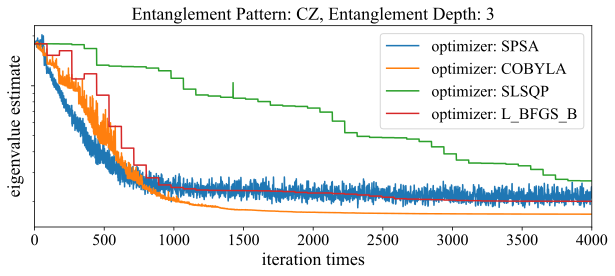

In [ ]:
# Direct plot from data stored in Python

pylab.rcParams['figure.figsize'] = (10,8)
fig = plt.figure(dpi=600)
ax = fig.add_subplot(2, 1, 2)

for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label='optimizer: '+type(optimizer).__name__)
pylab.yscale('log')

xlimit = 4000
pylab.xlim(0, xlimit)

csfont = {'fontname':'Times New Roman'}
pylab.title('Entanglement Pattern: CZ, Entanglement Depth: 3', **csfont, size=18)
pylab.xlabel('iteration times', **csfont, size=18)
pylab.ylabel('eigenvalue estimate', **csfont, size=18)

ticks_font = fm.FontProperties(
    family='Times New Roman', style='normal', size=16, weight='normal', stretch='normal')
for label in pylab.gca().get_xticklabels (): # get current axes
    label.set_fontproperties(ticks_font)
for label in pylab.gca().get_yticklabels ():
    label.set_fontproperties(ticks_font)
pylab.gca().yaxis.set_ticklabels([])

props = dict({'size': 16, 'family': 'Times New Roman', 'weight': 'normal', 'style': 'normal'})
pylab.legend(loc='best', prop=props)

pylab.show()

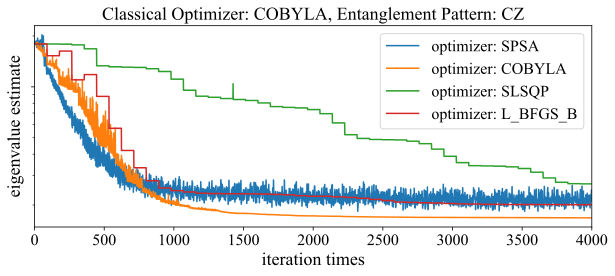

In [ ]:
# Draw data from Excel and plot

pylab.rcParams['figure.figsize'] = (10,8)
fig = plt.figure(dpi=600)
ax = fig.add_subplot(2, 1, 2)

xlimit = 4000
file = pd.read_excel(path_to_excel, nrows = xlimit)
x = np.array([file['A'], file['B'], file['C'], file['D'],])
y = np.array([file['E'], file['F'], file['G'], file['H']])

for i, optimizer in enumerate(optimizers):
    pylab.plot(x[i], y[i], label='optimizer: '+type(optimizer).__name__)
# pylab.xscale('log')
pylab.yscale('log')

xlimit = 4000
pylab.xlim(0, xlimit)

csfont = {'fontname':'Times New Roman'}
pylab.title('Classical Optimizer: COBYLA, Entanglement Pattern: CZ', **csfont, size=18)
pylab.xlabel('iteration times', **csfont, size=18)
pylab.ylabel('eigenvalue estimate', **csfont, size=18)

ticks_font = fm.FontProperties(
    family='Times New Roman', style='normal', size=16, weight='normal', stretch='normal')
for label in pylab.gca().get_xticklabels (): # get current axes
    label.set_fontproperties(ticks_font)
for label in pylab.gca().get_yticklabels ():
    label.set_fontproperties(ticks_font)
    
pylab.gca().yaxis.set_ticklabels([])

props = dict({'size': 16, 'family': 'Times New Roman', 'weight': 'normal', 'style': 'normal'})
pylab.legend(loc='best', prop=props)

pylab.show()

In [22]:
# Monitor via logging

import logging
logging.basicConfig(level=logging.INFO) # set the logging level to INFO
logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)

# This will generate detailed log files